# Когда-нибудь это закончится? Симуляция распространения болезни. Работа с NetworkX

<b>Цель.</b> Перед вами не совсем стандартное домашнее задание, так как в нём практически не будет машинного обучения (если не считать анализа графов), но будет довольно много аналитики, симуляций, визуализаций и очень интересных выводов. Так как не совсем про ML, то и выполнять это задание не обязательно для успешного завершения курса. Но если вам интересно узнать, как можно смоделировать распространение инфекции по международной сети аэропортов, увидеть, как заражение аэропортов-хабов приводит к взрывному росту заболеваний и создать свой локальный Plague Inc., то давайте приступать :)

<b>Описание/Пошаговая инструкция выполнения домашнего задания:</b>

Набор данных представляет собой основные маршруты авиаперелетов в США за один месяц 2008-го года. В качестве модели распространения инфекции предлагается использовать SI (susceptible-infected) модель, в которой каждый аэропорт имеет два возможных состояния - “здоровый” или “зараженный”. Здоровый аэропорт может заразиться с некоторой вероятностью p (infection probability), если к нему прилетает самолет из зараженного города. Инфекция начинает распространение из некоторого стартового аэропорта и заканчивает распространение, когда все перелеты из датасета завершены.
https://www.kaggle.com/datasets/vikalpdongre/us-flights-data-2008

<b>Часть 1. Пишем симуляцию.</b>
* Напишите функцию для симуляции одного прохода по всему датасету и распространения инфекции. Функция должна принимать на вход стартовый город, в котором изначально началась инфекция и вероятность распространения инфекции p. На выходе функция должна возвращать словарь, в котором ключом будет время заражения аэропорта, значением - название аэропорта. В теле функции вам нужно написать проход по всему датасету (имеет смысл использовать itertuples), где вы будете проверять, является ли текущий рейс “заразным” и если да - с вероятностью p заражать новый аэропорт.
* В качестве стартовой ноды/аэропорта для симуляций можно использовать Allentown (node_id = 0).

<b>Часть 2. Как инфекционность (вероятность заражения) болезни влияет на скорость распространения?</b>
* Давайте посмотрим, насколько заразной должна быть болезнь, чтобы заразить все аэропорты в сети. Для каждой из вероятностей p=[0.01, 0.05, 0.1, 0.5, 1.] прогоните по 10 симуляций распространения, каждый раз сохраняя результаты.
* Для каждых 12 часов симуляции посчитайте, какой средний процент аэропортов от общего их числа, был заражен к этому моменту времени. Постройте графики числа зараженных городов в зависимости от времени для каждой из вероятностей.

<b>Часть 3. Может ли информация о сети помочь предсказать, кто будет заражён?</b>
* Настало время поработать с NetworkX. По имеющемуся датасету вам нужно построить ненаправленный граф всех аэропортов, используя относительное число перелетов между соседними аэропортами в качестве веса ребра. Например, если из аэропорта А в аэропорт Б суммарно есть 5 рейсов, из Б в А 10 рейсов, а всего в сети 150 перелетов, то вес ребра между А и Б должен быть равен (5+10)/150 = 0.1.
* Прогоните вашу симуляцию 50 раз, используя p=0.5 и стартовый аэропорт Allentown, каждый раз сохраняя результаты. Используя данные симуляций посчитайте медианное время до заражения каждого города.
* Теперь используя построенный вами граф, для каждого города посчитайте его коэффициент кластеризации (nx.clustering), степень (nx.degree) и центральность (nx.betweenness_centrality).
* Наконец, постройте scatter-plot-ы для медианного времени заражения и каждой из рассчитанных выше метрик. Также посчитайте коэффициент корреляции Спирмана между этими показателями и попробуйте проинтерпретировать полученные результаты. Какая из метрик графа сильнее всего скоррелирована со временем заражения? Почему?

При выполнении домашнего задания использовался notebook: https://www.kaggle.com/code/artyomkolas/homework-graphs#Data-preparation

# Предварительный просмотр данных.

Скачаем датасет с https://www.kaggle.com/datasets/vikalpdongre/us-flights-data-2008

Импортируем основные библиотеки.

In [44]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

Считываем данные из CSV-файла. Выводим первые 5 строк, чтобы убедиться, что данные считались с локального файла.

In [45]:
df = pd.read_csv('2008.csv',)
pd.set_option('display.max_columns', None)
df.head()

Year  Month  DayofMonth  DayOfWeek  DepTime  CRSDepTime  ArrTime  \
0  2008      1           3          4   2003.0        1955   2211.0   
1  2008      1           3          4    754.0         735   1002.0   
2  2008      1           3          4    628.0         620    804.0   
3  2008      1           3          4    926.0         930   1054.0   
4  2008      1           3          4   1829.0        1755   1959.0   

   CRSArrTime UniqueCarrier  FlightNum TailNum  ActualElapsedTime  \
0        2225            WN        335  N712SW              128.0   
1        1000            WN       3231  N772SW              128.0   
2         750            WN        448  N428WN               96.0   
3        1100            WN       1746  N612SW               88.0   
4        1925            WN       3920  N464WN               90.0   

   CRSElapsedTime  AirTime  ArrDelay  DepDelay Origin Dest  Distance  TaxiIn  \
0           150.0    116.0     -14.0       8.0    IAD  TPA       810     4.0   
1           145.0    113.0       2.0      19.0    IAD  TPA       810     5.0   
2            90.0     76.0      14.0       8.0    IND  BWI       515     3.0   
3            90.0     78.0      -6.0      -4.0    IND  BWI       515     3.0   
4            90.0     77.0      34.0      34.0    IND  BWI       515     3.0   

   TaxiOut  Cancelled CancellationCode  Diverted  CarrierDelay  WeatherDelay  \
0      8.0          0              NaN         0           NaN           NaN   
1     10.0          0              NaN         0           NaN           NaN   
2     17.0          0              NaN         0           NaN           NaN   
3      7.0          0              NaN         0           NaN           NaN   
4     10.0          0              NaN         0           2.0           0.0   

   NASDelay  SecurityDelay  LateAircraftDelay  
0       NaN            NaN                NaN  
1       NaN            NaN                NaN  
2       NaN            NaN                NaN  
3       NaN            NaN                NaN  
4       0.0            0.0               32.0

Посмотрим на количество записей в файле.

In [46]:
df.shape

(7009728, 29)

Посмотрим, какого типа эти данные:

In [47]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7009728 entries, 0 to 7009727
Data columns (total 29 columns):
 #   Column             Dtype  
---  ------             -----  
 0   Year               int64  
 1   Month              int64  
 2   DayofMonth         int64  
 3   DayOfWeek          int64  
 4   DepTime            float64
 5   CRSDepTime         int64  
 6   ArrTime            float64
 7   CRSArrTime         int64  
 8   UniqueCarrier      object 
 9   FlightNum          int64  
 10  TailNum            object 
 11  ActualElapsedTime  float64
 12  CRSElapsedTime     float64
 13  AirTime            float64
 14  ArrDelay           float64
 15  DepDelay           float64
 16  Origin             object 
 17  Dest               object 
 18  Distance           int64  
 19  TaxiIn             float64
 20  TaxiOut            float64
 21  Cancelled          int64  
 22  CancellationCode   object 
 23  Diverted           int64  
 24  CarrierDelay       float64
 25  WeatherDelay      

Посмотрим на количество уникальных записей для каждого признака:

In [48]:
df.apply(lambda x: x.nunique())

Year                    1
Month                  12
DayofMonth             31
DayOfWeek               7
DepTime              1440
CRSDepTime           1217
ArrTime              1440
CRSArrTime           1378
UniqueCarrier          20
FlightNum            7539
TailNum              5373
ActualElapsedTime     689
CRSElapsedTime        525
AirTime               663
ArrDelay             1153
DepDelay             1134
Origin                303
Dest                  304
Distance             1435
TaxiIn                190
TaxiOut               342
Cancelled               2
CancellationCode        4
Diverted                2
CarrierDelay          984
WeatherDelay          599
NASDelay              574
SecurityDelay         156
LateAircraftDelay     564
dtype: int64

In [49]:
# Вывод уникальных значений столбца Origin
unique_origins = ', '.join(df['Origin'].unique())
print("Уникальные значения Origin:", unique_origins)

# Вывод уникальных значений столбца Dest
unique_destinations = ', '.join(df['Dest'].unique())
print("Уникальные значения Dest:", unique_destinations)

Уникальные значения Origin: IAD, IND, ISP, JAN, JAX, LAS, LAX, LBB, LIT, MAF, MCI, MCO, MDW, MHT, MSY, OAK, OKC, OMA, ONT, ORF, PBI, PDX, PHL, PHX, PIT, PVD, RDU, RNO, RSW, SAN, SAT, SDF, SEA, SFO, SJC, SLC, SMF, SNA, STL, TPA, TUL, TUS, ABQ, ALB, AMA, AUS, BDL, BHM, BNA, BOI, BUF, BUR, BWI, CLE, CMH, CRP, DAL, DEN, DTW, ELP, FLL, GEG, HOU, HRL, ROC, DAY, ORD, EWR, SYR, IAH, LFT, MKE, CHS, LCH, CLT, BTR, CRW, FAT, COS, MRY, LGB, BFL, EUG, ICT, MEM, LGA, DCA, BTV, GRK, BRO, TYS, DSM, BPT, GPT, GRR, PWM, MSP, RIC, CVG, SAV, SRQ, GSO, CHA, XNA, GSP, LEX, MFE, ABE, MLU, MOB, LRD, SHV, TLH, CAE, AEX, ATL, DFW, BGR, AVL, BOS, MSN, HSV, MGM, MYR, VPS, CLL, PNS, MTJ, DAB, PSP, ASE, ATW, AVP, BMI, CAK, CID, CLD, COD, CPR, CWA, DRO, EGE, FLG, FSD, FWA, GJT, GRB, HDN, HNL, ILM, ITO, JFK, KOA, LAN, LIH, MBS, MDT, MFR, OGG, RAP, ROA, SBA, SBN, SBP, SPI, TEX, YUM, TVC, HPN, MIA, MLB, SGF, TRI, ACY, TWF, SUN, PIH, EKO, SGU, PSC, BTM, SLE, IDA, HLN, FCA, MSO, GTF, LWS, YKM, BZN, BIL, RDM, FAR, JAC, IY

Посмотрим на основные статистические характеристики данных, такие как среднее значение, стандартное отклонение, минимальное и максимальное значения, и квартили.

In [51]:
df.describe()

Year         Month    DayofMonth     DayOfWeek       DepTime  \
count  7009728.0  7.009728e+06  7.009728e+06  7.009728e+06  6.873482e+06   
mean      2008.0  6.375130e+00  1.572801e+01  3.924182e+00  1.333830e+03   
std          0.0  3.406737e+00  8.797068e+00  1.988259e+00  4.780689e+02   
min       2008.0  1.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00   
25%       2008.0  3.000000e+00  8.000000e+00  2.000000e+00  9.280000e+02   
50%       2008.0  6.000000e+00  1.600000e+01  4.000000e+00  1.325000e+03   
75%       2008.0  9.000000e+00  2.300000e+01  6.000000e+00  1.728000e+03   
max       2008.0  1.200000e+01  3.100000e+01  7.000000e+00  2.400000e+03   

         CRSDepTime       ArrTime    CRSArrTime     FlightNum  \
count  7.009728e+06  6.858079e+06  7.009728e+06  7.009728e+06   
mean   1.326086e+03  1.481258e+03  1.494801e+03  2.224200e+03   
std    4.642509e+02  5.052251e+02  4.826728e+02  1.961716e+03   
min    0.000000e+00  1.000000e+00  0.000000e+00  1.000000e+00   
25%    9.250000e+02  1.107000e+03  1.115000e+03  6.220000e+02   
50%    1.320000e+03  1.512000e+03  1.517000e+03  1.571000e+03   
75%    1.715000e+03  1.909000e+03  1.907000e+03  3.518000e+03   
max    2.359000e+03  2.400000e+03  2.400000e+03  9.743000e+03   

       ActualElapsedTime  CRSElapsedTime       AirTime      ArrDelay  \
count       6.855029e+06    7.008884e+06  6.855029e+06  6.855029e+06   
mean        1.273224e+02    1.288668e+02  1.040186e+02  8.168452e+00   
std         7.018731e+01    6.940974e+01  6.743980e+01  3.850194e+01   
min         1.200000e+01   -1.410000e+02  0.000000e+00 -5.190000e+02   
25%         7.700000e+01    8.000000e+01  5.500000e+01 -1.000000e+01   
50%         1.100000e+02    1.100000e+02  8.600000e+01 -2.000000e+00   
75%         1.570000e+02    1.590000e+02  1.320000e+02  1.200000e+01   
max         1.379000e+03    1.435000e+03  1.350000e+03  2.461000e+03   

           DepDelay      Distance        TaxiIn       TaxiOut     Cancelled  \
count  6.873482e+06  7.009728e+06  6.858079e+06  6.872670e+06  7.009728e+06   
mean   9.972570e+00  7.263870e+02  6.860852e+00  1.645305e+01  1.960618e-02   
std    3.531127e+01  5.621018e+02  4.933649e+00  1.133280e+01  1.386426e-01   
min   -5.340000e+02  1.100000e+01  0.000000e+00  0.000000e+00  0.000000e+00   
25%   -4.000000e+00  3.250000e+02  4.000000e+00  1.000000e+01  0.000000e+00   
50%   -1.000000e+00  5.810000e+02  6.000000e+00  1.400000e+01  0.000000e+00   
75%    8.000000e+00  9.540000e+02  8.000000e+00  1.900000e+01  0.000000e+00   
max    2.467000e+03  4.962000e+03  3.080000e+02  4.290000e+02  1.000000e+00   

           Diverted  CarrierDelay  WeatherDelay      NASDelay  SecurityDelay  \
count  7.009728e+06  1.524735e+06  1.524735e+06  1.524735e+06   1.524735e+06   
mean   2.463006e-03  1.577206e+01  3.039031e+00  1.716462e+01   7.497434e-02   
std    4.956753e-02  4.009912e+01  1.950287e+01  3.189495e+01   1.837940e+00   
min    0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   0.000000e+00   
25%    0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   0.000000e+00   
50%    0.000000e+00  0.000000e+00  0.000000e+00  6.000000e+00   0.000000e+00   
75%    0.000000e+00  1.600000e+01  0.000000e+00  2.100000e+01   0.000000e+00   
max    1.000000e+00  2.436000e+03  1.352000e+03  1.357000e+03   3.920000e+02   

       LateAircraftDelay  
count       1.524735e+06  
mean        2.077098e+01  
std         3.925964e+01  
min         0.000000e+00  
25%         0.000000e+00  
50%         0.000000e+00  
75%         2.600000e+01  
max         1.316000e+03

# Часть 1. Пишем симуляцию.

Для нашей задачи нам понадобятся дата и время, аэропорты отправления и назначения, время вылета и прибытия.
</br>Соответственно нам интересны следующие столбцы:
* Year (Год).
* Month (Месяц).
* DayofMonth (День месяца).
* CRSDepTime (запланированное время отправления (местное, ччмм, целое число)).
* CRSArrTime (запланированное время прибытия (местное, чччм, целое число)).
* Origin (код аэропорта IATA отправления).
* Dest (код аэропорта IATA назначения).

</br>Поскольку время указано в местном часовом поясе, мы извлекем отсюда http://https//raw.githubusercontent.com/hroptatyr/dateutils/tzmaps/iata.tzmap часовые пояса и будем использовать их при преобразовании даты и времени в utc.

Кроме того, мы решили, что день отправления рейса - это день месяца, поэтому нам нужно контролировать ночные рейсы.

In [52]:
# Получение информации о часовых поясах аэропортов
airport_tz = pd.read_fwf(
    'https://raw.githubusercontent.com/hroptatyr/dateutils/tzmaps/iata.tzmap',
    names=['code', 'tz'],
    colspecs=[(0, 3), (3, None)]
)

# Убедимся, что в нашем наборе данных присутствуют все аэропорты
airports = pd.Series(df['Origin'].unique())

codes = airport_tz.code.unique()
bad = [ap not in codes for ap in airports]
for a in airports[bad]:
    print(a)

PFN


PFN - закрытый аэропорт в Панама-Сити, штат Флорида. Он имеет часовой пояс Америка/Чикаго. Поэтому мы добавим в набор данных airport_tz новую запись:

In [53]:
# Добавим время в часовой пояс аэропорта
airport_tz.loc[len(airport_tz.index)] = ['PFN', 'America/Chicago']
# Создадим индекс кода
airport_tz.index = airport_tz['code'].values
# airport_tz.
# show tail
airport_tz.tail(2)

code                tz
ZZV  ZZV  America/New_York
PFN  PFN   America/Chicago

In [54]:
df[['CRSDepTime', 'CRSArrTime']].describe()

CRSDepTime    CRSArrTime
count  7.009728e+06  7.009728e+06
mean   1.326086e+03  1.494801e+03
std    4.642509e+02  4.826728e+02
min    0.000000e+00  0.000000e+00
25%    9.250000e+02  1.115000e+03
50%    1.320000e+03  1.517000e+03
75%    1.715000e+03  1.907000e+03
max    2.359000e+03  2.400000e+03

Время задано целым числом, также мы видим, что CRSArrTime равно 2.400000e+03 (2400), что предположительно равно 00:00 следующего дня, для простоты мы изменим его на 23:59.

In [55]:
import dateutil
from datetime import datetime, timedelta, timezone
import pytz

def to_time(int_var):
    """
    Возвращает время, записанное в виде целого числа, и форматирует его как время (24 часа) в строковом формате.
    Примеры:
    1 -> 00:01
    41 -> 00:41
    537 -> 05:37
    1714 -> 17:14
    """
    str_var = str(int_var).rjust(4, '0')
    return str_var[:2] + ':' + str_var[2:]

@np.vectorize
def get_tz(code):
    """
    Возвращает часовой пояс в виде файла dateutil.tz.tz.tzfile из кода аэропорта
    """
    tz = dateutil.tz.gettz(airport_tz.loc[code, 'tz'])
    return tz

@np.vectorize
def to_datetime(year, month, day, time, tz):
    """
    Возвращает дату и время в формате UTC
    """
    h, m = time.split(sep=':')
    result = datetime(year, month, day, int(h), int(m), tzinfo=None).astimezone(pytz.utc)#.replace(tzinfo=None)
    return result
    #return np.datetime64(result)

def preprocess(df):
    
    # Заменим 24:00 на 23:53
    df.loc[df['CRSArrTime'] >= 2400, 'CRSArrTime'] = 2359
    df.loc[df['CRSDepTime'] >= 2400, 'CRSArrTime'] = 2359
    
    # Создаём столбец с указанием времени отправления и прибытия в виде строки
    df['arr_time'] = df['CRSArrTime'].apply(to_time)
    df['dep_time'] = df['CRSDepTime'].apply(to_time)
    
    # Создаём столбцы даты и времени
    df['arr_datetime'] = to_datetime(df['Year'], df['Month'], df['DayofMonth'], df['arr_time'], get_tz(df['Dest'].iloc[0]))
    df['dep_datetime'] = to_datetime(df['Year'], df['Month'], df['DayofMonth'], df['dep_time'], get_tz(df['Origin'].iloc[0]))
    
    # Оставим только нужные столбцы
    result = df[['dep_datetime', 'Origin', 'arr_datetime', 'Dest']]

    # Переименуем столбцы
    result.columns = ['departure', 'origin', 'arrival', 'dst']
    
    # Контролируем ночные полёты
    result.loc[result['departure'] > result['arrival'], 'arrival'] += timedelta(hours=24)

    # Сортируем по времени отправления
    result.sort_values('departure', inplace=True)
    
    return result

Выполним предварительную обработку данных, сохраним их в CSV-файл.

In [57]:
# df = preprocess(df).reset_index(drop=True)
# df.to_csv('dataset.csv')

In [58]:
%%time

df = pd.read_csv('dataset.csv', index_col=0)

# Столбцы 'departure' и 'arrival' в DataFrame df преобразуются
# из строкового формата в формат даты и времени с учётом часового пояса UTC.
df['departure'] = df['departure'].astype('datetime64[ns, UTC]')
df['arrival'] = df['arrival'].astype('datetime64[ns, UTC]')

print(df.dtypes)
df

departure    datetime64[ns, UTC]
origin                    object
arrival      datetime64[ns, UTC]
dst                       object
dtype: object
CPU times: total: 1min 52s
Wall time: 1min 52s


departure origin                   arrival  dst
0       2007-12-31 21:10:00+00:00    LAX 2008-01-01 04:37:00+00:00  DTW
1       2007-12-31 21:15:00+00:00    SMF 2008-01-01 05:23:00+00:00  JFK
2       2007-12-31 21:25:00+00:00    SMF 2008-01-01 02:35:00+00:00  DFW
3       2007-12-31 21:25:00+00:00    PHX 2008-01-01 04:09:00+00:00  JFK
4       2007-12-31 21:30:00+00:00    LAX 2008-01-01 03:05:00+00:00  MSP
...                           ...    ...                       ...  ...
7009723 2008-12-31 20:59:00+00:00    PDX 2009-01-01 02:47:00+00:00  IAH
7009724 2008-12-31 20:59:00+00:00    PHX 2009-01-01 02:22:00+00:00  ATL
7009725 2008-12-31 20:59:00+00:00    HNL 2009-01-01 04:05:00+00:00  SFO
7009726 2008-12-31 20:59:00+00:00    JFK 2009-01-01 01:44:00+00:00  SJU
7009727 2008-12-31 20:59:00+00:00    JFK 2009-01-01 01:39:00+00:00  BQN

[7009728 rows x 4 columns]

In [59]:
# Создаём новый DataFrame ABE,
# который содержит только те строки из исходного DataFrame df, где значение в столбце "origin" равно 'ABE'.
# Таким образом, фильтруются только данные, связанные с аэропортом с кодом 'ABE'.
ABE = df[df['origin'] == 'ABE']
print(len(ABE))
ABE[:20]

4807


departure origin                   arrival  dst
457   2008-01-01 03:05:00+00:00    ABE 2008-01-01 04:55:00+00:00  DTW
1720  2008-01-01 04:20:00+00:00    ABE 2008-01-01 05:34:00+00:00  ORD
3084  2008-01-01 05:40:00+00:00    ABE 2008-01-01 07:22:00+00:00  CLT
7298  2008-01-01 09:05:00+00:00    ABE 2008-01-01 11:20:00+00:00  ATL
7497  2008-01-01 09:15:00+00:00    ABE 2008-01-01 11:07:00+00:00  DTW
7798  2008-01-01 09:30:00+00:00    ABE 2008-01-01 10:47:00+00:00  ORD
9877  2008-01-01 11:10:00+00:00    ABE 2008-01-01 12:25:00+00:00  CLE
12498 2008-01-01 13:15:00+00:00    ABE 2008-01-01 15:08:00+00:00  DTW
13993 2008-01-01 14:20:00+00:00    ABE 2008-01-01 16:43:00+00:00  ATL
14408 2008-01-01 14:40:00+00:00    ABE 2008-01-01 15:59:00+00:00  CLE
14470 2008-01-01 14:41:00+00:00    ABE 2008-01-01 15:56:00+00:00  ORD
19402 2008-01-02 03:00:00+00:00    ABE 2008-01-02 04:14:00+00:00  ORD
19693 2008-01-02 03:00:00+00:00    ABE 2008-01-02 05:18:00+00:00  ATL
19857 2008-01-02 03:05:00+00:00    ABE 2008-01-02 04:55:00+00:00  DTW
20031 2008-01-02 03:15:00+00:00    ABE 2008-01-02 05:08:00+00:00  CVG
20654 2008-01-02 03:40:00+00:00    ABE 2008-01-02 04:59:00+00:00  CLE
21665 2008-01-02 04:20:00+00:00    ABE 2008-01-02 05:34:00+00:00  ORD
23462 2008-01-02 05:40:00+00:00    ABE 2008-01-02 07:22:00+00:00  CLT
25816 2008-01-02 07:28:00+00:00    ABE 2008-01-02 08:43:00+00:00  CLE
28038 2008-01-02 09:10:00+00:00    ABE 2008-01-02 11:25:00+00:00  ATL

Напишем функцию do_simulation, которая выполняет симуляцию распространения инфекции на основе предоставленного DataFrame с данными о перелётах.

In [60]:
def do_simulation(df, airport, init_dt, p, np_seed, verbose=False):
    """
    Запустите симуляцию распространения инфекции
    :параметр df: pd.DataFrame
        данные для итерации
    :параметр airport: str
        код аэропорта, который был изначально заражен
    :параметр init_dt: datetime64[ns, UTC]
        время начала моделирования распространения инфекции
    :параметр p: float
        вероятность заражения нового аэропорта
    :параметр verbose: bool, по умолчанию False
        Если значение True, выводится информация о заражении
    :параметр np_seed: int
        изменяет значение np.random.seed() с нуля на значение np_seed
    :return: dict
        словарь распространения инфекции. В качестве ключа используется дата и время, а в качестве данных - код аэропорта.
    """
    
    # инициализируем генератор случайных чисел np.random.seed(np_seed) и устанавим временную метку начала моделирования
    np.random.seed(np_seed)
    initial_time = pd.Timestamp(init_dt)

    infected = [airport]
    results = {airport: initial_time} # Заражённый аэропорт и его время заражения добавляются в словарь results
    time_df = df[df['departure'] > initial_time] # фильтруем только строки, где время вылета позже начальной временной метки
    
    # Проверяем вероятность заражения нового аэропорта и,
    # если аэропорт назначения находится в зараженных и не был заражён ранее,
    # и вероятность выполняется, то аэропорт назначения добавляется в заражённые,
    # а его время заражения сохраняется
    if verbose:
        print(len(infected), '  infected  ', airport, '  ', results[airport])
        
    for row in time_df.itertuples():
        
        chance = np.random.uniform()
        if (row.origin in infected) and (row.dst not in infected) and (chance <= p):

            infected.append(row.dst)
            results[row.dst] = row.arrival
            if verbose:
                print(len(infected), '  infected  ', row.dst, '  ', row.arrival)
        else:
            continue
    # Функция выводит количество заражённых аэропортов в текущем временном диапазоне и процент от общего числа аэропортов
    N = len(df['dst'].unique())
    print('Infected : ', len(results),'/',N, '    precent: ', (len(results)/N)*100, '%' )
    
    # Возвращаем словарь с распространением инфекции, где ключом является время и дата, а значением - код зараженного аэропорта
    return results

Код Allentown - ABE. Запустим симуляцию распространения инфекции на основе предоставленных параметров и данных, выводя информацию о заражении на каждом этапе моделирования.

In [61]:
from datetime import datetime, timedelta, timezone # работа с датами и временем
import pytz # управление часовыми поясами

init_airport = 'ABE' # устанавим исходный аэропорт для запуска модели заражения

# Создаём объект времени init_dt с указанными годом, месяцем, днём и временем (в UTC)
init_dt = to_datetime([2008], [1], [1], ['00:00'], [pytz.utc])[0]
p = 0.5 # Устанавим вероятность заражения нового аэропорта
np_seed = 10 # Устанавим начальное значение для генератора случайных чисел

# Запускаем симуляцию распространения инфекции с указанными параметрами,
# флаг verbose=True используется для вывода информации о заражении в процессе выполнения симуляции
res = do_simulation(df, init_airport, init_dt, p, np_seed, verbose=True)

1   infected   ABE    2007-12-31 21:00:00+00:00
2   infected   ORD    2008-01-01 05:34:00+00:00
3   infected   PHX    2008-01-01 07:16:00+00:00
4   infected   EWR    2008-01-01 07:25:00+00:00
5   infected   FLL    2008-01-01 07:40:00+00:00
6   infected   RDU    2008-01-01 07:15:00+00:00
7   infected   SFO    2008-01-01 07:15:00+00:00
8   infected   JAX    2008-01-01 06:02:00+00:00
9   infected   SLC    2008-01-01 07:24:00+00:00
10   infected   LAX    2008-01-01 07:00:00+00:00
11   infected   DFW    2008-01-01 07:05:00+00:00
12   infected   DEN    2008-01-01 08:01:00+00:00
13   infected   DTW    2008-01-01 06:50:00+00:00
14   infected   ASE    2008-01-01 05:38:00+00:00
15   infected   SJC    2008-01-01 05:50:00+00:00
16   infected   FAT    2008-01-01 05:41:00+00:00
17   infected   SEA    2008-01-01 07:52:00+00:00
18   infected   XNA    2008-01-01 05:50:00+00:00
19   infected   CVG    2008-01-01 09:16:00+00:00
20   infected   MCO    2008-01-01 07:37:00+00:00
21   infected   TOL    2008-0

263   infected   IPL    2008-01-03 03:47:00+00:00
264   infected   MOT    2008-01-02 07:33:00+00:00
265   infected   CHO    2008-01-02 07:40:00+00:00
266   infected   BRW    2008-01-02 07:19:00+00:00
267   infected   EYW    2008-01-02 08:39:00+00:00
268   infected   SIT    2008-01-02 08:25:00+00:00
269   infected   TRI    2008-01-02 10:25:00+00:00
270   infected   DHN    2008-01-03 09:50:00+00:00
271   infected   FLO    2008-01-02 11:05:00+00:00
272   infected   BTM    2008-01-02 11:34:00+00:00
273   infected   SPI    2008-01-02 11:20:00+00:00
274   infected   LYH    2008-01-02 13:00:00+00:00
275   infected   BQK    2008-01-02 16:38:00+00:00
276   infected   LCH    2008-01-02 17:48:00+00:00
277   infected   VLD    2008-01-02 17:55:00+00:00
278   infected   TUP    2008-01-02 19:03:00+00:00
279   infected   BQN    2008-01-03 07:38:00+00:00
280   infected   ROW    2008-01-03 17:35:00+00:00
281   infected   YKM    2008-01-03 18:56:00+00:00
282   infected   RHI    2008-01-04 13:58:00+00:00


Выполним преобразование и обработку данных в DataFrame data_viz на основе результатов симуляции распространения инфекции, добавив столбец counts с порядковыми номерами строк. Выведем информацию о полученном DataFrame.

In [62]:
# Создаём новый DataFrame data_viz из словаря res, который был получен после выполнения симуляции распространения инфекции
# Параметр orient='index' указывает, что ключи словаря будут использоваться в качестве индексов DataFrame
data_viz = pd.DataFrame.from_dict(res, orient='index')

# Сбрасываем индексы DataFrame data_viz, делая текущие индексы столбцом
# Индексами будут значения по порядку от 0 до N-1, где N - общее количество строк в DataFrame
data_viz = data_viz.reset_index()

# Создаём новый столбец counts в DataFrame data_viz, который содержит значения индексов DataFrame, увеличенные на 1
# Таким образом, в этом столбце будут содержаться порядковые номера строк, начиная с 1.
data_viz['counts'] = data_viz.index + 1
data_viz

index                         0  counts
0     ABE 2007-12-31 21:00:00+00:00       1
1     ORD 2008-01-01 05:34:00+00:00       2
2     PHX 2008-01-01 07:16:00+00:00       3
3     EWR 2008-01-01 07:25:00+00:00       4
4     FLL 2008-01-01 07:40:00+00:00       5
..    ...                       ...     ...
299   OTH 2008-07-07 19:01:00+00:00     300
300   LMT 2008-07-08 09:36:00+00:00     301
301   ITH 2008-08-19 19:45:00+00:00     302
302   HTS 2008-10-01 08:17:00+00:00     303
303   PIR 2008-11-30 09:30:00+00:00     304

[304 rows x 3 columns]

Построим линейный график на основе данных из DataFrame data_viz, где на оси x будут значения из столбца с индексом 0, а на оси y - значения из столбца 'counts'.

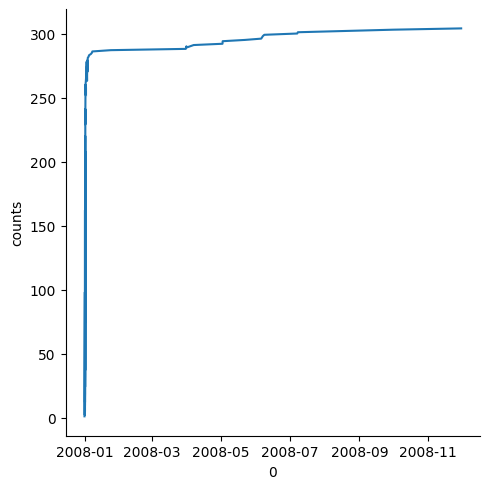

In [63]:
sns.relplot(data=data_viz[[0, 'counts']], kind='line', x=0, y='counts')

Напишем функцию, которая возвращает DataFrame с результатами всех симуляций, где каждая строка представляет результат одной конкретной симуляции распространения инфекции в зависимости от заданных вероятностей.

In [64]:
def run_simulations(df, airport, init_dt, probs, n, verbose=False):
    
    # Создаём пустой DataFrame results с колонками 'p', 'sim_id', 'airport', 'infected',
    # в который будут сохраняться результаты симуляций
    results = pd.DataFrame(columns=['p', 'sim_id', 'airport', 'infected'])
    
    # Напишем цикл по вероятностям probs для проведения симуляций с разными вероятностями заражения
    for p in probs:
        print('Моделирование для определения вероятности = ', p)
        
        # Для каждой вероятности p выполняем вложенный цикл for i in range(n),
        # где n - количество симуляций. Генерируется новый np_seed для каждой симуляции
        for i in range(n):
            np_seed = i

            # Для каждой итерации симуляции вызываем функция do_simulation,
            # которая выполняет одну симуляцию распространения инфекции и возвращает результат в виде DataFrame sim_res
            sim_res = pd.DataFrame.from_dict(do_simulation(
                df,
                airport,
                init_dt,
                p,
                np_seed,
                verbose=verbose), orient='index').reset_index()
    
            # Преобразуем DataFrame sim_res
            sim_res.columns = ['airport', 'infected']
            sim_res['sim_id'] = i
            sim_res['p'] = p
            
            # Результаты текущей симуляции объединим с общим DataFrame results с помощью pd.concat()
            results = pd.concat([results, sim_res]) 
        print('\n\n')
    
    # Возвращаем DataFrame results, содержащий результаты всех запущенных симуляций с разными вероятностями
    return results

# Часть 2. Как инфекционность (вероятность заражения) болезни влияет на скорость распространения?

* Давайте посмотрим, насколько заразной должна быть болезнь, чтобы заразить все аэропорты в сети. Для каждой из вероятностей p=[0.01, 0.05, 0.1, 0.5, 1.] прогоните по 10 симуляций распространения, каждый раз сохраняя результаты.
* Для каждых 12 часов симуляции посчитайте, какой средний процент аэропортов от общего их числа, был заражен к этому моменту времени. Постройте графики числа зараженных городов в зависимости от времени для каждой из вероятностей.

In [65]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

init_airport = 'ABE' # устанавим код исходного аэропорта 'ABE'

# Создаём объект времени init_dt с указанными годом (2008), месяцем (декабрь), днем (1) и временем (00:00) в часовом поясе UTC
init_dt = to_datetime([2008], [12], [1], ['00:00'], [pytz.utc])[0]

probs = [0.01, 0.05, 0.1, 0.5, 1] # список вероятностей заражения, для которых будут проведены симуляции
n_simulations = 10 # количество симуляций, которые будут проведены для каждой вероятности заражения

print('Первый заражённый аэропорт:', init_airport, pd.Timestamp(init_dt),'\n\n')

results_df = run_simulations(df, init_airport, init_dt, probs, n_simulations, verbose=False)
results_df.to_csv('results_df.csv')

Первый заражённый аэропорт: ABE 2008-11-30 21:00:00+00:00 


Моделирование для определения вероятности =  0.01
Infected :  229 / 304     precent:  75.32894736842105 %
Infected :  197 / 304     precent:  64.80263157894737 %
Infected :  199 / 304     precent:  65.46052631578947 %
Infected :  216 / 304     precent:  71.05263157894737 %
Infected :  208 / 304     precent:  68.42105263157895 %
Infected :  211 / 304     precent:  69.4078947368421 %
Infected :  224 / 304     precent:  73.68421052631578 %
Infected :  236 / 304     precent:  77.63157894736842 %
Infected :  220 / 304     precent:  72.36842105263158 %
Infected :  220 / 304     precent:  72.36842105263158 %



Моделирование для определения вероятности =  0.05
Infected :  275 / 304     precent:  90.46052631578947 %
Infected :  278 / 304     precent:  91.44736842105263 %
Infected :  273 / 304     precent:  89.80263157894737 %
Infected :  275 / 304     precent:  90.46052631578947 %
Infected :  277 / 304     precent:  91.11842105263158

Напишем функцию get_time_spreading(df), которая принимает DataFrame df с результатами симуляций распространения инфекции и возвращает словарь tsim_res, содержащий информацию о распространении инфекции во времени.

In [66]:
def get_time_spreading(df):
    
    # Опредлим количество уникальных аэропортов N, минимальное и максимальное время заражения в DataFrame
    N = len(df['airport'].unique())
    min_time = df['infected'].min()
    max_time = df['infected'].max()
    print(f'From {min_time} to {max_time}')

    # словарь для записи результатов
    tsim_res = dict()

    # временная разница
    dt = timedelta(hours=12)

    # временной момент
    tp = min_time
    
    # цикл, в котором для каждого временного момента tp, меньшего максимального времени заражения,
    # вычисляется процент зараженных аэропортов для каждой вероятности заражения p
    # результаты агрегируются и среднее значение процента зараженных для каждой вероятности заражения
    # записывается в словарь tsim_res по соответствующему временному моменту tp
    while tp < max_time:
        infected_pct = results_df[results_df.infected <= tp].groupby(['p', 'sim_id']).size()/N * 100
        infected_pct = infected_pct.reset_index().groupby('p')[0].mean()
        tsim_res[tp] = infected_pct
        tp += dt
    return tsim_res

tsim_res = get_time_spreading(results_df)

From 2008-11-30 21:00:00+00:00 to 2008-12-31 23:43:00+00:00


Напишем функцию visualise_spreading(), которая построит график для визуализации среднего процента заражённых аэропортов в зависимости от времени с разными уровнями вероятности заражения.

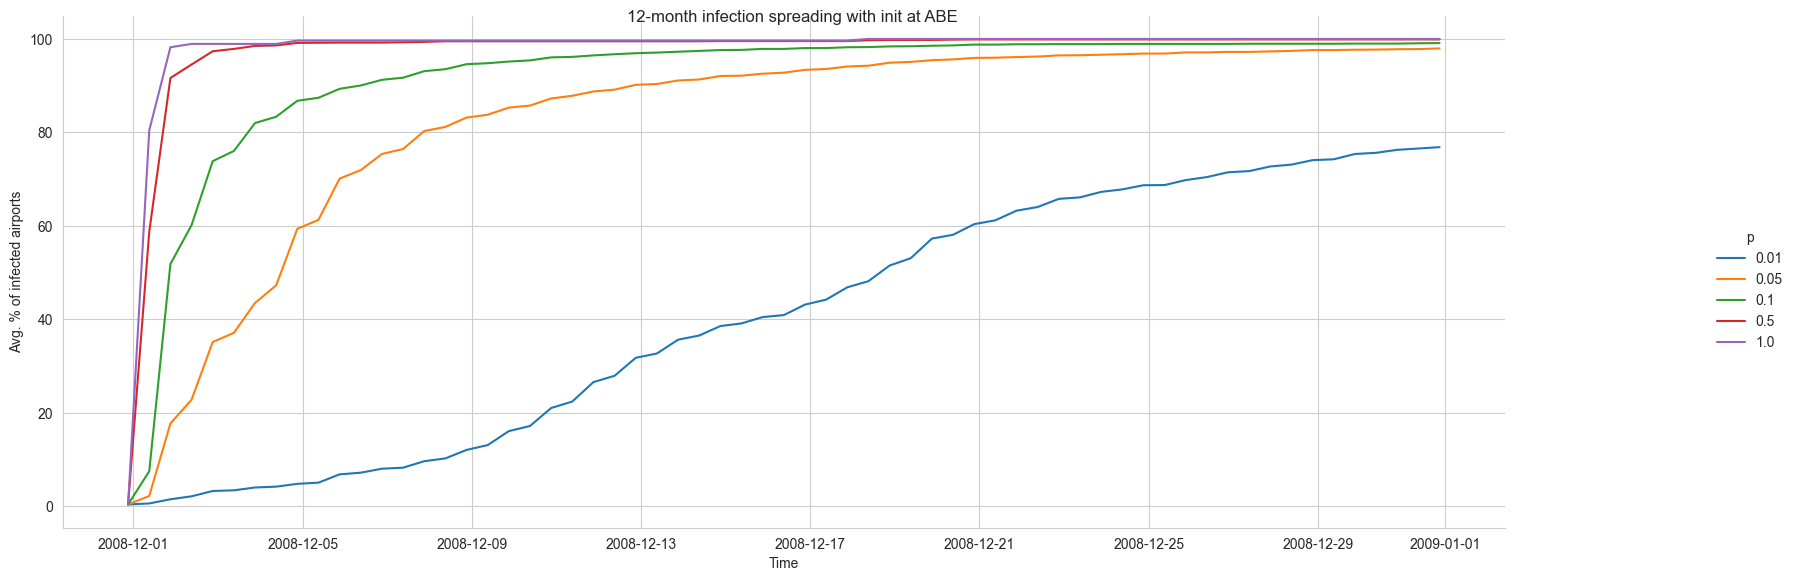

In [67]:
def visualise_spreading(tsim_res, num_month, airport):
    # Создадим dataframe для визуализации
    data_viz = pd.DataFrame.from_dict(tsim_res, orient='index')
    data_viz = data_viz.reset_index().melt(id_vars='index', var_name='p')
    data_viz['p'] = data_viz.p.astype('category') # столбец 'p' приведём к категориальному типу
    # Визуализация
    sns.set_style('whitegrid')
    lp = sns.relplot(data=data_viz, kind='line', x='index', y='value', hue='p')
    lp.fig.set_figwidth(20)
    lp.fig.set_figheight(6)
    lp.fig.suptitle(f'{num_month}-month infection spreading with init at {airport}')
    lp.ax.set_xlabel('Time')
    lp.ax.set_ylabel('Avg. % of infected airports')
    plt.show()
    
visualise_spreading(tsim_res, 12, init_airport)

# Часть 3. Может ли информация о сети помочь предсказать, кто будет заражен?

* Настало время поработать с NetworkX. По имеющемуся датасету вам нужно построить ненаправленный граф всех аэропортов, используя относительное число перелетов между соседними аэропортами в качестве веса ребра. Например, если из аэропорта А в аэропорт Б суммарно есть 5 рейсов, из Б в А 10 рейсов, а всего в сети 150 перелетов, то вес ребра между А и Б должен быть равен (5+10)/150 = 0.1.
* Прогоните вашу симуляцию 50 раз, используя p=0.5 и стартовый аэропорт Allentown, каждый раз сохраняя результаты. Используя данные симуляций посчитайте медианное время до заражения каждого города.
* Теперь используя построенный вами граф, для каждого города посчитайте его коэффициент кластеризации (nx.clustering), степень (nx.degree) и центральность (nx.betweenness_centrality).
* Наконец, постройте scatter-plot-ы для медианного времени заражения и каждой из рассчитанных выше метрик. Также посчитайте коэффициент корреляции Спирмана между этими показателями и попробуйте проинтерпретировать полученные результаты. Какая из метрик графа сильнее всего скоррелирована со временем заражения? Почему?

Выполним обработку данных о рейсах между аэропортами, вычислим количество связей между аэропортами и сохраним результаты в CSV-файл для последующего анализа и визуализации.

In [70]:
# Декоратор применяется к функции combine_orig_dst,
# чтобы позволить ей принимать не только скалярные значения, но и массивы значений, достигая векторизации операций
@np.vectorize
def combine_orig_dst(origin, dst):
    """
    Combine airport codes in aphabetical order
    """
    if origin < dst:
        result = f'{origin} {dst}'
    else:
        result = f'{dst} {origin}'
    return result

In [71]:
# NF устанавливается равным количеству строк в DataFrame df, что соответствует общему количеству рейсов
NF = df.shape[0]

# Создадим список рёбер из dataframe

# Создадим новый столбец 'edge' в DataFrame df,
# в который записываются результаты объединения кодов аэропортов из столбцов 'origin' и 'dst'
# с помощью функции combine_orig_dst
df['edge'] = combine_orig_dst(df.origin, df.dst)

# Вычислим частоту (вероятность) появления каждой пары аэропортов в столбце 'edge' и нормализуем на общее количество рейсов
edgelist = df.groupby('edge').size()/NF

# Результаты рассчётов сгруппированных данных объединим в новый DataFrame edgelist, сбрасим индекс группировки
edgelist = edgelist.reset_index()

# Создадим столбцы 'node1' и 'node2', в которых каждая строка разделяется изначального столбца 'edge' по пробелу
edgelist[['node1', 'node2']] = edgelist['edge'].str.split(' ', expand=True)

# Выбирем только столбцы 'node1', 'node2' и первый столбец (с индексом 0) из edgelist
edgelist = edgelist[['node1', 'node2', 0]]

# Присвоим новые имена столбцам в edgelist: 'node1', 'node2' и 'weight'
edgelist.columns = ['node1', 'node2', 'weight']

# Результаты вычислений сохраним в CSV-файл с именем 'edgelist.csv'
edgelist.to_csv('edgelist.csv', header=False, index=False, sep=' ')
edgelist

node1 node2        weight
0      ABE   ATL  2.432334e-04
1      ABE   BHM  1.426589e-07
2      ABE   CLE  2.296808e-04
3      ABE   CLT  1.326728e-04
4      ABE   CVG  7.061615e-05
...    ...   ...           ...
2829   STL   TUL  2.552168e-04
2830   SUN   TWF  4.279767e-07
2831   SWF   TPA  6.704968e-05
2832   TLH   TPA  8.588065e-05
2833   TUL   XNA  1.426589e-07

[2834 rows x 3 columns]

Создадим граф на основе данных, загруженных из CSV-файла с помощью библиотеки NetworkX, вычислим его распределение по кругу и визуализируем его, отображая узлы, рёбра и метки на графике.

In [72]:
import networkx as nx # для работы с графами

# Создание графа на основе взвешенного списка рёбер, загруженного из файла 'edgelist.csv'
# В данном случае, все узлы задаются как строки
ag = nx.read_weighted_edgelist('edgelist.csv', nodetype=str)

# Вывод количества узлов и рёбер в созданном графе
print(ag.number_of_nodes(), 'nodes and ', ag.number_of_edges(), 'edges in the graph')

305 nodes and  2834 edges in the graph


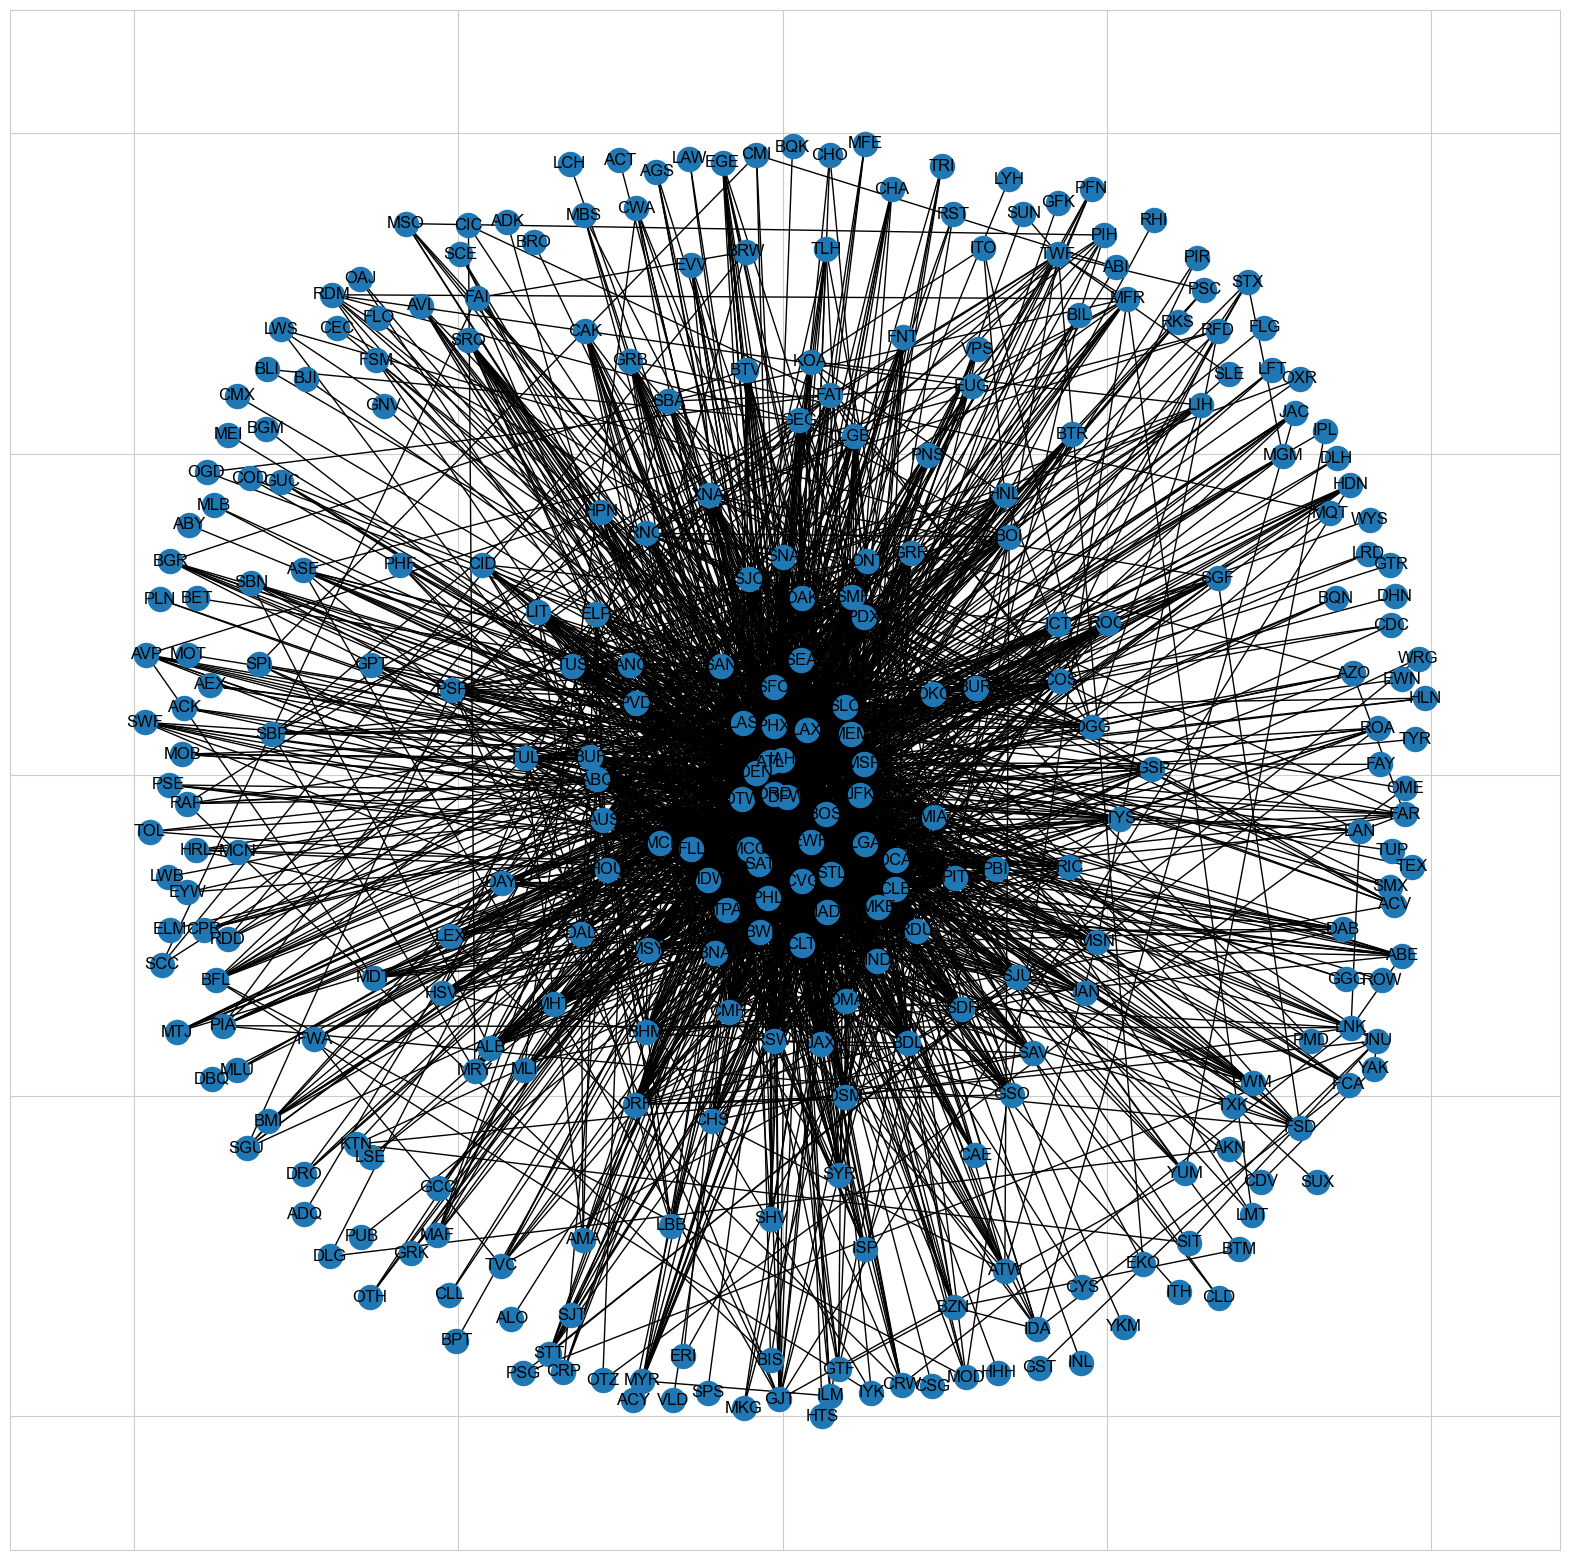

In [73]:
fig = plt.figure(1, figsize=(20, 20)) # cоздание фигуры для построения графика с заданным размером 20x20
nx.draw_networkx(ag) # настройка отображения графа с помощью библиотеки NetworkX

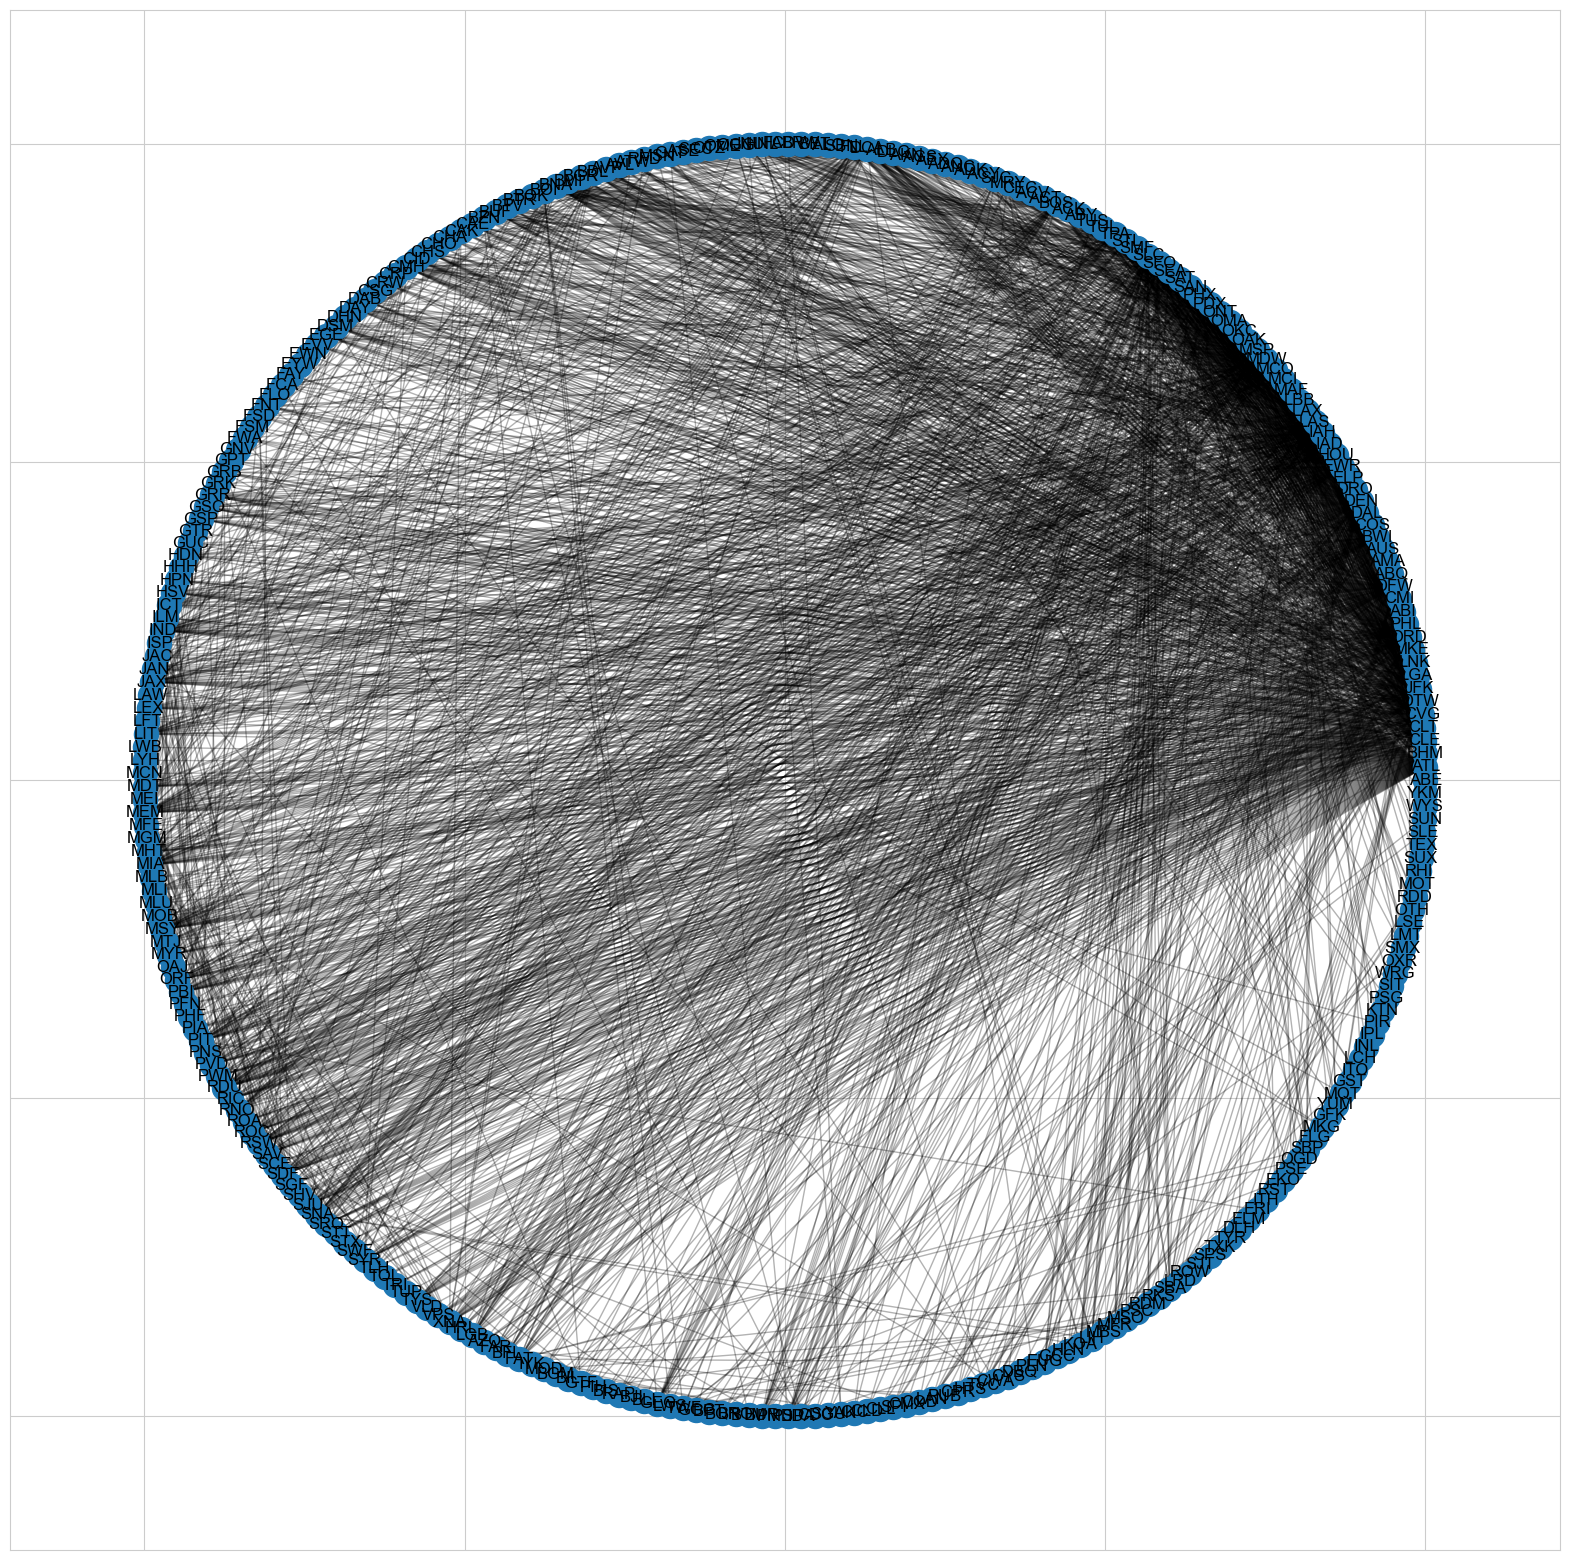

In [74]:
fig = plt.figure(1, figsize=(20, 20)) # создадим новую фигуру с тем же размером
pos=nx.circular_layout(ag) # вычислем позиции узлов для круговой разметки графа
nx.draw_networkx_nodes(ag,pos=pos) # отобразим узлы графа с использованием предварительно вычисленных позиций
nx.draw_networkx_edges(ag,pos=pos,alpha=0.3) # отобразим рёбра графа с использованием заданных позиций, уровень прозрачности 0.3
nx.draw_networkx_labels(ag, pos=pos) # добавим метки к узлам графа с использованием заданных позиций
plt.show()

Вычислим различные метрики для узлов графа ag с учётом веса рёбер, а затем комбинируем эти метрики в DataFrame node_metrics и выведем описание статистик для полученных метрик.

In [75]:
clustering = nx.clustering(ag, weight='weight') # коэффициент кластеризации
degree = dict(ag.degree(weight='weight')) # степень
centrality = nx.betweenness_centrality(ag, weight='weight') # центральность

Создадим DataFrame node_metrics, содержащий вычисленные метрики (коэффициент кластеризации, степень и центральность) для каждого узла в графе.

In [76]:
# Объединим метрики в DataFrame
node_metrics =  pd.DataFrame.from_dict(clustering ,orient='index', columns=['clustering']).join([
                pd.DataFrame.from_dict(degree ,orient='index', columns=['degree']),
                pd.DataFrame.from_dict(centrality ,orient='index', columns=['centrality'])
])
node_metrics

clustering    degree  centrality
ABE    0.025966  0.001370    0.001032
ATL    0.022777  0.118269    0.127454
BHM    0.042371  0.006756    0.020993
CLE    0.033988  0.018772    0.000000
CLT    0.042964  0.035961    0.044871
..          ...       ...         ...
TEX    0.000000  0.000055    0.000000
SLE    0.007017  0.000138    0.000000
SUN    0.014566  0.000824    0.000000
WYS    0.000000  0.000075    0.000000
YKM    0.000000  0.000097    0.000000

[305 rows x 3 columns]

Выведем статистическое описание для DataFrame node_metrics, включающее среднее, стандартное отклонение, минимальное, максимальное и квартили для каждой вычисленной метрики.

In [77]:
node_metrics.describe()

clustering        degree  centrality
count  305.000000  3.050000e+02  305.000000
mean     0.039208  6.557377e-03    0.017303
std      0.033406  1.436104e-02    0.035015
min      0.000000  2.853178e-07    0.000000
25%      0.011779  3.684879e-04    0.000000
50%      0.036350  1.211745e-03    0.000000
75%      0.057230  4.621863e-03    0.018181
max      0.178200  1.182691e-01    0.208582

Выполним серию шагов для моделирования эпидемии в аэропортах и вычисления времени, прошедшего до заражения в различных аэропортах в часах.

In [78]:
init_airport = 'ABE' # устанавим исходный аэропорт для запуска модели заражения

# Создаём объект времени init_dt с указанными годом (2008), месяцем (декабрь), днем (1) и временем (00:00) в часовом поясе UTC
init_dt = to_datetime([2008], [12], [1], ['00:00'], [pytz.utc])[0]
probs = [0.5] # список вероятностей заражения, для которых будут проведены симуляции
n_simulations = 50 # количество симуляций для выполнения

# Запускаем симуляцию распространения инфекции с указанными параметрами
results_50 = run_simulations(df, init_airport, init_dt, probs, n_simulations, verbose=False)
results_50.to_csv('sim50res.csv') # сохраним результаты симуляции в CSV файл 'sim50res.csv'

Моделирование для определения вероятности =  0.5
Infected :  281 / 304     precent:  92.43421052631578 %
Infected :  281 / 304     precent:  92.43421052631578 %
Infected :  281 / 304     precent:  92.43421052631578 %
Infected :  281 / 304     precent:  92.43421052631578 %
Infected :  281 / 304     precent:  92.43421052631578 %
Infected :  280 / 304     precent:  92.10526315789474 %
Infected :  281 / 304     precent:  92.43421052631578 %
Infected :  281 / 304     precent:  92.43421052631578 %
Infected :  280 / 304     precent:  92.10526315789474 %
Infected :  280 / 304     precent:  92.10526315789474 %
Infected :  280 / 304     precent:  92.10526315789474 %
Infected :  281 / 304     precent:  92.43421052631578 %
Infected :  281 / 304     precent:  92.43421052631578 %
Infected :  280 / 304     precent:  92.10526315789474 %
Infected :  281 / 304     precent:  92.43421052631578 %
Infected :  281 / 304     precent:  92.43421052631578 %
Infected :  281 / 304     precent:  92.43421052631578 %

In [79]:
results_50 = pd.read_csv('sim50res.csv', index_col=0) # считаем данные из файла 'sim50res.csv' в DataFrame results_50

# Преобразуем столбец 'infected' в тип данных datetime64 с временной зоной UTC
results_50['infected'] = results_50['infected'].astype('datetime64[ns, UTC]')
# results_50['dt'] = results_50['dt'].astype('timedelta64[ns]')
results_50

p  sim_id airport                  infected
0    0.5       0     ABE 2008-11-30 21:00:00+00:00
1    0.5       0     DTW 2008-12-01 11:04:00+00:00
2    0.5       0     EVV 2008-12-01 09:43:00+00:00
3    0.5       0     DEN 2008-12-01 10:32:00+00:00
4    0.5       0     FCA 2008-12-01 11:43:00+00:00
..   ...     ...     ...                       ...
276  0.5      49     FLO 2008-12-04 10:10:00+00:00
277  0.5      49     SCE 2008-12-04 12:34:00+00:00
278  0.5      49     PIR 2008-12-08 05:55:00+00:00
279  0.5      49     TEX 2008-12-18 08:40:00+00:00
280  0.5      49     ADK 2008-12-18 13:22:00+00:00

[14038 rows x 4 columns]

In [80]:
results_50.dtypes

p                       float64
sim_id                    int64
airport                  object
infected    datetime64[ns, UTC]
dtype: object

In [81]:
# Сбросим индексы в DataFrame results_50
results_50 = results_50.reset_index(drop=True) 

# Определим начальное время заражения из первой записи
st = results_50.loc[0, 'infected'] 
st

# Вычислим разницу во времени между каждым заражением и начальным заражением
results_50['dt'] = results_50['infected'] - st

# Вычислим медианное время до заражения для каждого аэропорта в секундах
median_time = results_50.groupby('airport')['dt'].median().astype('timedelta64[s]')

# Проверим, что в вычисленном медианном значении времени нет пропущенных значений
assert median_time.isna().sum() == 0

In [82]:
median_time

airport
ABE   0 days 00:00:00
ABI   0 days 13:45:00
ABQ   0 days 08:40:00
ABY   0 days 10:54:00
ACT   0 days 15:05:00
            ...      
VPS   0 days 10:05:00
WRG   1 days 09:27:00
XNA   0 days 09:25:00
YAK   1 days 02:32:30
YUM   0 days 11:53:00
Name: dt, Length: 281, dtype: timedelta64[s]

In [83]:
results_50

p  sim_id airport                  infected               dt
0      0.5       0     ABE 2008-11-30 21:00:00+00:00  0 days 00:00:00
1      0.5       0     DTW 2008-12-01 11:04:00+00:00  0 days 14:04:00
2      0.5       0     EVV 2008-12-01 09:43:00+00:00  0 days 12:43:00
3      0.5       0     DEN 2008-12-01 10:32:00+00:00  0 days 13:32:00
4      0.5       0     FCA 2008-12-01 11:43:00+00:00  0 days 14:43:00
...    ...     ...     ...                       ...              ...
14033  0.5      49     FLO 2008-12-04 10:10:00+00:00  3 days 13:10:00
14034  0.5      49     SCE 2008-12-04 12:34:00+00:00  3 days 15:34:00
14035  0.5      49     PIR 2008-12-08 05:55:00+00:00  7 days 08:55:00
14036  0.5      49     TEX 2008-12-18 08:40:00+00:00 17 days 11:40:00
14037  0.5      49     ADK 2008-12-18 13:22:00+00:00 17 days 16:22:00

[14038 rows x 5 columns]

In [84]:
# Объединим метрики узлов и медианное время до заражения в единый DataFrame
ap_metrics = node_metrics.join(median_time)

# Преобразуем разницу во времени из секунд в часы, сохраняя результаты в новом столбце 'hours' в DataFrame
ap_metrics['hours'] = ap_metrics['dt'].dt.total_seconds()/60/60

# Выводим окончательные метрики аэропортов с добавленным временем до заражения в часах
ap_metrics

clustering    degree  centrality               dt       hours
ABE    0.025966  0.001370    0.001032  0 days 00:00:00    0.000000
ATL    0.022777  0.118269    0.127454  0 days 08:28:30    8.475000
BHM    0.042371  0.006756    0.020993  0 days 08:41:00    8.683333
CLE    0.033988  0.018772    0.000000  0 days 08:06:00    8.100000
CLT    0.042964  0.035961    0.044871  0 days 08:40:00    8.666667
..          ...       ...         ...              ...         ...
TEX    0.000000  0.000055    0.000000 17 days 12:51:00  420.850000
SLE    0.007017  0.000138    0.000000              NaT         NaN
SUN    0.014566  0.000824    0.000000  0 days 12:37:00   12.616667
WYS    0.000000  0.000075    0.000000              NaT         NaN
YKM    0.000000  0.000097    0.000000              NaT         NaN

[305 rows x 5 columns]

Визуализируем отношения между временем до заражения и другими метриками, а также визуализируем коэффициенты корреляции Спирмена между этими метриками и временем до заражения.

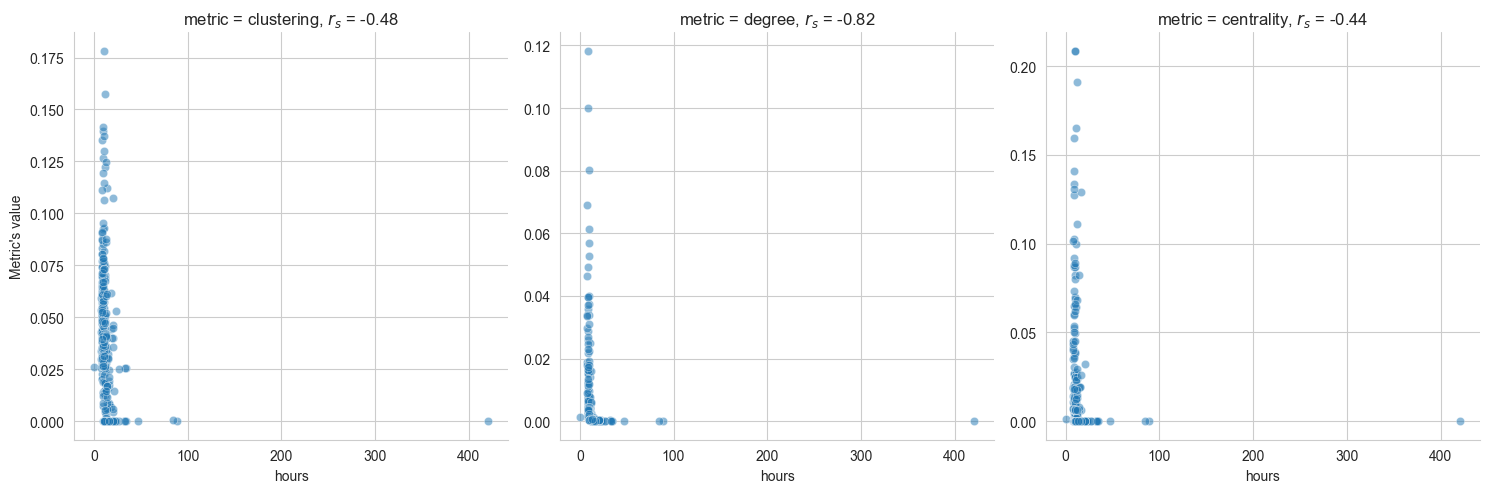

In [85]:
# Рассчитываем коэффициент корреляции Спирмена между временем до заражения (в часах) и всеми остальными метриками в ap_metrics
scorr = ap_metrics.drop('dt', axis=1).corr('spearman').loc['hours']

# Создаём DataFrame ap_viz для визуализации, объедим данные о времени до заражения, метриках и их значениях
ap_viz = ap_metrics.drop('dt', axis=1).reset_index().melt(id_vars=['index', 'hours'], var_name='metric')

# Устанавливаем стиль для графиков Seaborn
sns.set_style('whitegrid')

# Создаём реляционный график (relplot) для визуализации столбцов 'hours' и 'value'
# в зависимости от различных метрик, с отдельными графиками для каждой метрики
sp = sns.relplot(data=ap_viz, x='hours', y='value', col='metric', facet_kws={'sharey': False, 'sharex': True}, alpha=0.5)


# Изменяем подпись по оси Y на "Metric's value"
sp.set_ylabels("Metric's value")

# Получаем все оси графика
axes = sp.fig.axes

# В цикле изменяем заголовки каждой оси, добавляя информацию о коэффициенте корреляции Спирмена для соответствующей метрики
for ax in axes:
    current_title = ax.get_title()
    metric_name = current_title.split(' ')[2]
    title = f'{current_title}, $r_{{s}}$ = {round(scorr[metric_name], 2)}'
    ax.set_title(title)
plt.show()

<b>Вывод:</b>
Исходя из полученных значений коэффициентов корреляции Спирмана, можно сказать, что метрика "degree" сильнее всего скоррелирована со временем заражения, так как коэффициент корреляции для этой метрики составляет -0,82, что близко к -1.
Коэффициент корреляции показывает степень линейной зависимости между двумя переменными. По модулю, близкий к 1 коэффициент указывает на сильную линейную связь между переменными. В данном случае, коэффициент корреляции -0,82 между метрикой "degree" и временем заражения означает обратную зависимость: чем выше значение метрики "degree", тем меньше времени требуется для заражения.
Таким образом, метрика "degree" оказывает наибольшее влияние на время заражения в сравнении с другими рассмотренными метриками графа, что делает её наиболее сильно скоррелированной с временем заражения в данном конкретном случае.